In [19]:
import numpy as np
import sys
print(sys.executable)
from mpl_toolkits import mplot3d


import deepxde as dde

# 用于绘图
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

a = 1
b = 2
k_r = 1.5
k_i = 1
v_1 = 1
v_2 = 1
v_3 = 1
c = np.log((a * a * v_1 + b * b * v_2 + a * b * v_3 + a * b * v_3) / ((2 * k_r) * (2 * k_r)))
print(sys.executable)
#周期性边界条件
x_lower = -10*np.pi
x_upper = 10*np.pi
t_lower = -2
t_upper =2

# 创建 2D 域（用于绘图和输入）
x = np.linspace(x_lower, x_upper, 512)
t = np.linspace(t_lower, t_upper, 402)
X, T = np.meshgrid(x, t)

# 整个域变平
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# 空间和时间域/几何（对于 deepxde 模型）
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)
# 损失的“物理信息”部分


def pde(x,y):
    """
    INPUTS:
        x: x[:,0] 是 x 坐标
           x[:,1] 是 t 坐标
        y: 网络输出，在这种情况下:
            y[:,0] 是 u(x,t) 实部
            y[:,1] 是 v(x,t) 虚部
    OUTPUT:
        标准形式的 pde，即必须为零的东西
    """
    
    
    u1 = y[:, 0:1]
    v1 = y[:, 1:2]
    u2 = y[:, 2:3]
    v2 = y[:, 3:4]
    

    # 在'jacobian'中，i 是输出分量，j 是输入分量
    u1_t = dde.grad.jacobian(y, x, i=0, j=1)
    v1_t = dde.grad.jacobian(y, x, i=1, j=1)
    u2_t = dde.grad.jacobian(y, x, i=2, j=1)
    v2_t = dde.grad.jacobian(y, x, i=3, j=1)

    u1_x = dde.grad.jacobian(y, x, i=0, j=0)
    v1_x = dde.grad.jacobian(y, x, i=1, j=0)
    u2_x = dde.grad.jacobian(y, x, i=2, j=0)
    v2_x = dde.grad.jacobian(y, x, i=3, j=0)

    # 在“hessian”中，i 和 j 都是输入分量。 （Hessian 原则上可以是 d^2y/dxdt、d^2y/d^2x 等）
    # 输出组件由“组件”选择
    u1_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v1_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    u2_xx = dde.grad.hessian(y, x, component=2, i=0, j=0)
    v2_xx = dde.grad.hessian(y, x, component=3, i=0, j=0)

    #f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    #f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u

    r1=1
    r2=2
    r3=-1
    r4=0
    beta=1
    
    f_u1 = (
            v1_t + u1_xx
        + r1*u1*(u1**2 + v1**2) + r2*u1*(u2**2 + v2**2) + r3*(u1*(u2**2 - v2**2) + 2*u2*v1*v2) + r4*(u2*(u1**2 - v1**2) + 2*u1*v1*v2)
    )

    f_v1 = (
            -u1_t + v1_xx
        + r1*v1*(u1**2 + v1**2) + r2*v1*(u2**2 + v2**2) - r3*(v1*(u2**2 - v2**2) - 2*u1*u2*v2) - r4*(v2*(u1**2 - v1**2) - 2*u1*u2*v1)
    )

    f_u2 = (
            v2_t + beta*u2_xx
        + r1*u2*(u2**2 + v2**2) + r2*u2*(u1**2 + v1**2) + r3*(u2*(u1**2 - v1**2) + 2*u1*v2*v1) + r4*(u1*(u2**2 - v2**2) + 2*u2*v2*v1)
    )

    f_v2 = (
            -u2_t + beta*v2_xx
        + r1*v2*(u2**2 + v2**2) + r2*v2*(u1**2 + v1**2) - r3*(v2*(u1**2 - v1**2) - 2*u2*u1*v1) - r4*(v1*(u2**2 - v2**2) - 2*u2*u1*v2)
    )
    
    return [
        f_u1, f_v1, f_u2, f_v2,
        #f_u1x, f_u1t,
        #f_v1x, f_v1t,
        #f_u2x, f_u2t,
        #f_v2x, f_v2t
    ]
 # 边界条件和初始条件

# 周期性边界条件
bc_u1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)
bc_u2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=2
)
bc_u2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=2
)
bc_v2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=3
)
bc_v2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=3
)
#(e^c=...)
# 初始条件
def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], -1)

a=1
k=2
c1=10
c2=0
i=1j

def init_cond_u1(x):
    phi=a**2*t-k**2*t/2
    
    q11=((2+4*i*a**2*t)/(4*a**4*t**2+4*a**2*(k*t+x)**2+1)*np.exp(-i*k*x)+i*np.cos(k*x-np.pi/2))*a*np.exp(i*phi)
    
    result=q11.real
    
    
    #result=( (1/phi1)*(np.exp(-2*k1*k2*t + k1*x + nf1) * np.cos((-k1**2+k2**2)*t - k2*x - nf2))
     #       + (1/phi2)*(np.exp(-2*l1*l2*t + l1*x + ng1) * np.cos((-l1**2+l2**2)*t - l2*x - ng2))
     #      )
    return result
    
def init_cond_u2(x):
    phi=a**2*t-k**2*t/2
    
    q12=((2+4*i*a**2*t)/(4*a**4*t**2+4*a**2*(k*t+x)**2+1)*np.exp(-i*k*x)-np.sin(k*x+np.pi/2))*a*np.exp(i*phi)
    
    result=q12.real
    
    #result=( -(1/phi1)*(np.exp(-2*k1*k2*t + k1*x + nf1) * np.sin((-k1**2+k2**2)*t - k2*x - nf2))
     #       + (1/phi2)*(np.exp(-2*l1*l2*t + l1*x + ng1) * np.sin((-l1**2+l2**2)*t - l2*x - ng2))
      #     )
    return result

def init_cond_v1(x):
    phi=a**2*t-k**2*t/2
    
    q11=((2+4*i*a**2*t)/(4*a**4*t**2+4*a**2*(k*t+x)**2+1)*np.exp(-i*k*x)+i*np.cos(k*x-np.pi/2))*a*np.exp(i*phi)
    
    result=q11.imag
    #result=-( (1/phi1)*(np.exp(-2*k1*k2*t + k1*x + nf1) * np.sin((-k1**2+k2**2)*t - k2*x - nf2))
    #        + (1/phi2)*(np.exp(-2*l1*l2*t + l1*x + ng1) * np.sin((-l1**2+l2**2)*t - l2*x - ng2))
    #       )
    return result

def init_cond_v2(x):
    phi=a**2*t-k**2*t/2
    
    q12=((2+4*i*a**2*t)/(4*a**4*t**2+4*a**2*(k*t+x)**2+1)*np.exp(-i*k*x)-np.sin(k*x+np.pi/2))*a*np.exp(i*phi)
    
    result=q12.imag
    
    #result= ( -(1/phi1)*(np.exp(-2*k1*k2*t + k1*x + nf1) * np.cos((-k1**2+k2**2)*t - k2*x - nf2))
    #        + (1/phi2)*(np.exp(-2*l1*l2*t + l1*x + ng1) * np.cos((-l1**2+l2**2)*t - l2*x - ng2))
    #       )
    return result

ic_u1 = dde.IC(geomtime, init_cond_u1, lambda _, on_initial: on_initial, component=0)
ic_v1 = dde.IC(geomtime, init_cond_v1, lambda _, on_initial: on_initial, component=1)
ic_u2 = dde.IC(geomtime, init_cond_u2, lambda _, on_initial: on_initial, component=2)
ic_v2 = dde.IC(geomtime, init_cond_v2, lambda _, on_initial: on_initial, component=3)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u1_0, bc_u1_1, bc_v1_0, bc_v1_1,bc_u2_0, bc_u2_1, bc_v2_0, bc_v2_1, ic_u1, ic_v1,ic_u2, ic_v2],
    num_domain=5000,
    num_boundary=100,
    num_initial=100,
    train_distribution="pseudo",
)

allow_unused=True
# 网络架构
net = dde.maps.FNN([2] + [100] * 6 + [4], "silu", "Glorot normal")

model = dde.Model(data, net)

d:\anaconda\python.exe
d:\anaconda\python.exe


In [20]:
model.compile("adam", lr=1e-3, loss="MSE")
model.train(epochs=40000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.215649 s



C:\Users\86183\AppData\Roaming\Python\Python39\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


ValueError: operands could not be broadcast together with shapes (402,) (101,2) 

Compiling model...
'compile' took 2.102849 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
0         [6.28e-06, 1.18e-04, 3.54e-05, 4.78e-05, 8.29e-03, 3.24e-06, 2.93e-02, 1.50e-04, 2.29e-03, 7.23e-04, 6.33e-03, 8.26e-04, 3.55e-01, 1.52e-01, 1.56e-01, 3.69e-01]    [6.28e-06, 1.18e-04, 3.54e-05, 4.78e-05, 8.29e-03, 3.24e-06, 2.93e-02, 1.50e-04, 2.29e-03, 7.23e-04, 6.33e-03, 8.26e-04, 3.55e-01, 1.52e-01, 1.56e-01, 3.69e-01]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.851738
  Number of iterations: 634
  Number of functions evaluations: 695
695    

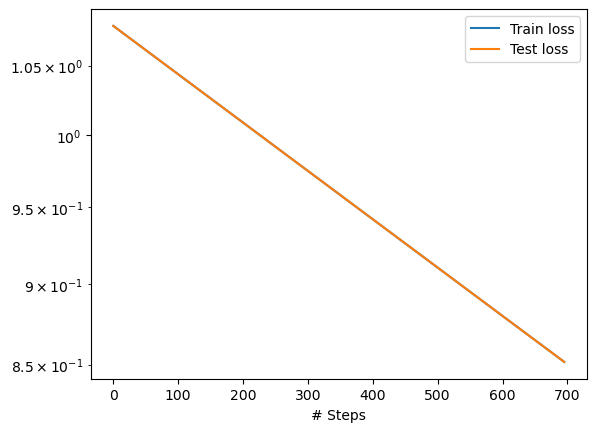

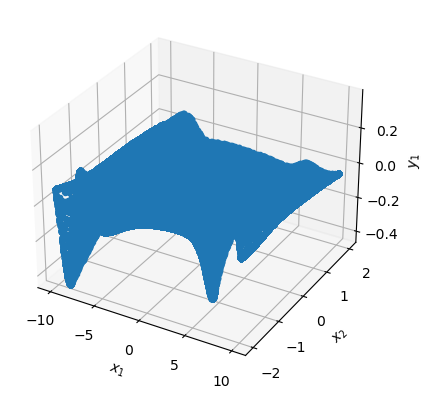

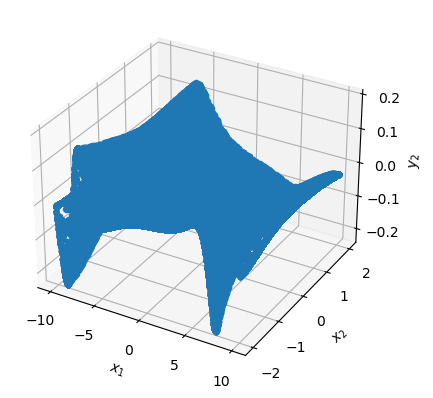

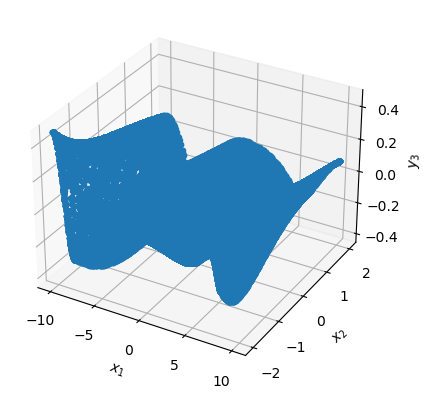

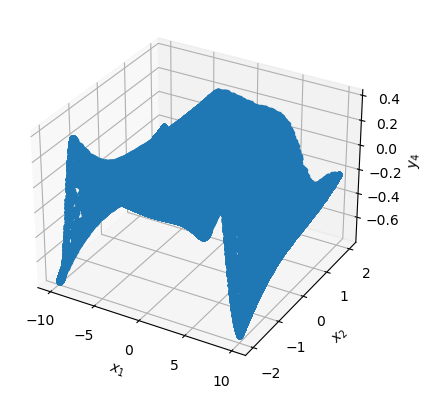

In [ ]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-09,
    maxiter=10000,
    maxfun=5000,
    maxls=50,
)
model.compile("L-BFGS")
#model.train()

losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

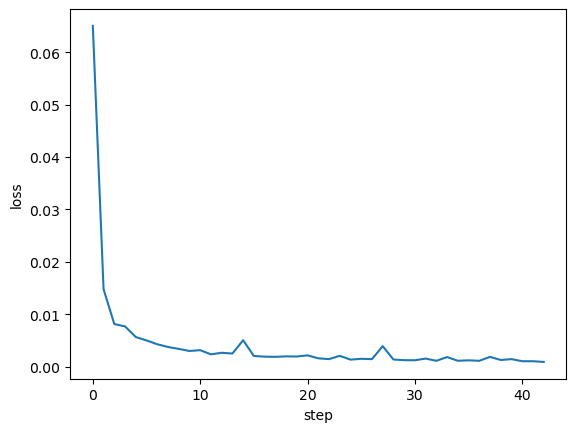

In [ ]:

loss_t = losshistory.loss_train



plt.plot(np.mean(loss_t,axis=1))
plt.xlabel("step")
plt.ylabel("loss")

print(losshistory)
print(train_state)

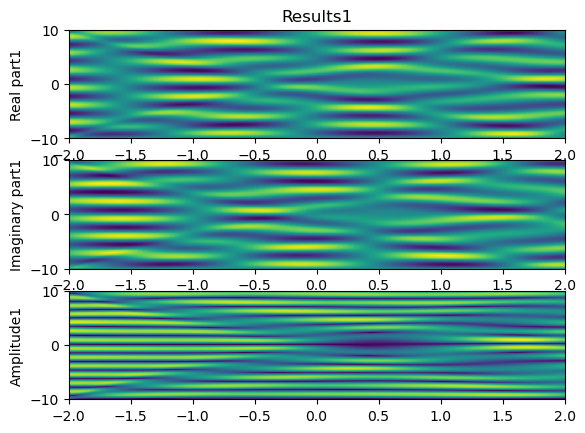

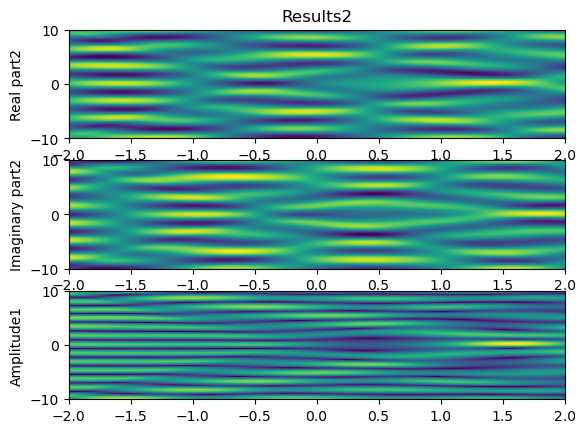

In [ ]:
# 做预测
prediction = model.predict(X_star, operator=None)

u1 = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v1 = griddata(X_star, prediction[:, 1], (X, T), method="cubic")
u2 = griddata(X_star, prediction[:, 2], (X, T), method="cubic")
v2 = griddata(X_star, prediction[:, 3], (X, T), method="cubic")


h1 = np.sqrt(u1 ** 2 + v1 ** 2)
h2=np.sqrt(u2**2+v2**2)



# 绘制预测
fig, ax = plt.subplots(3)

ax[0].set_title("Results1")
ax[0].set_ylabel("Real part1")
ax[0].imshow(
    u1.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part1")
ax[1].imshow(
    v1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude1")
ax[2].imshow(
    h1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

fig, bx = plt.subplots(3)
bx[0].set_title("Results2")
bx[0].set_ylabel("Real part2")
bx[0].imshow(
    u2.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
bx[1].set_ylabel("Imaginary part2")
bx[1].imshow(
    v2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
bx[2].set_ylabel("Amplitude1")
bx[2].imshow(
    h2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
plt.show()

[116882 140075 166867 ...  66454  36761  14766]


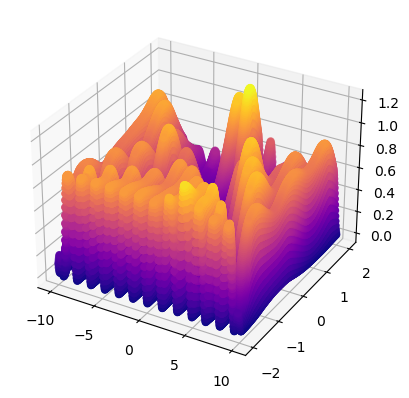

In [ ]:
ax = plt.axes(projection='3d')


b=prediction[:,0]**2+prediction[:,1]**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
# Data for a three-dimensional line
ax.scatter3D(X_star[:,0],X_star[:,1],b,c=d[:],cmap='plasma')

[138076 140362 143860 ... 104675 110247 114665]
(402, 512)
(402, 512)
(205824, 2)
(205824, 4)


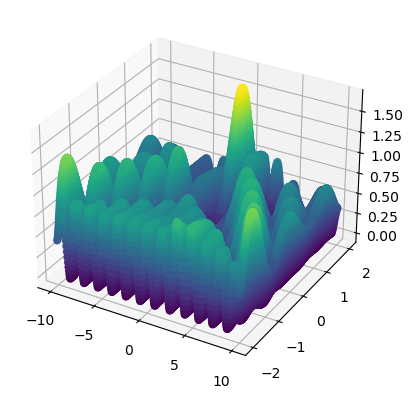

In [ ]:
bx = plt.axes(projection='3d')
b=prediction[:,2]**2+prediction[:,3]**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
bx.scatter3D(X_star[:,0],X_star[:,1],b,c=d[:]/10)

print(X.shape)
print(T.shape)
print(X_star.shape)
print(prediction.shape)

In [ ]:
print(c)

3.0723277e-06


In [ ]:
b=1
c=2
a=complex(b,c)
print(a)

(1+2j)


In [ ]:
z=-1j
print(z)

(-0-1j)


In [ ]:
print(z.imag)

-1.0


d:\anaconda\python.exe


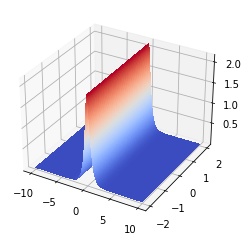

In [21]:
import random
import time
from matplotlib import cm
import numpy as np
import numpy as np
import sys
print(sys.executable)
from mpl_toolkits import mplot3d


import deepxde as dde

# 用于绘图
import matplotlib.pyplot as plt
from scipy.interpolate import griddata


# plot a 3D surface like in the example mplot3d/surface3d_demo
X = np.arange(-10, 10, 0.01)
T = np.arange(-2, 2, 0.01)
x, t = np.meshgrid(X, T)
i=1j
c11=1
c21=2
c31=2
c41=1
lambda1=0.01-1j

v1=(c31.conjugate()**2+c41.conjugate()**2)*(c11*c31+c21*c41)
v2=(c11**2+c21**2)*(c11.conjugate()**2+c21.conjugate()**2)
v3=(c31.conjugate()**2+c41.conjugate()**2)*(c21*c31-c11*c41)

eta1=np.log((c11**2+c21**2)*(c11.conjugate()*c31.conjugate()+c21.conjugate()*c41.conjugate())/v1)/2
eta2=np.log(v2/((c11*c11.conjugate()+c21*c21.conjugate())*(c31*c31.conjugate()+c41*c41.conjugate())))/2
eta3=np.log((c11**2+c21**2)*(c21*c31-c11*c41)/v3)/2
gamma1=(c31**2+c41**2)*(c31.conjugate()**2+c41.conjugate()**2)

xi1=-2*1j*lambda1**2*t-1j*lambda1*x
q1=4*v1*1j*(lambda1.conjugate()-lambda1)*np.exp(3*xi1+xi1.conjugate()+eta1)*np.cosh(xi1+xi1.conjugate()+eta1)/(2*v2*np.exp(3*(xi1+xi1.conjugate())+eta2)*np.cosh(xi1+xi1.conjugate()+eta2)+gamma1)
q2=4*v3*1j*(lambda1-lambda1.conjugate())*np.exp(3*xi1+xi1.conjugate()+eta3)*np.cosh(xi1+xi1.conjugate()+eta3)/(2*v2*np.exp(3*(xi1+xi1.conjugate())+eta2)*np.cosh(xi1+xi1.conjugate()+eta2)+gamma1)
q1=np.abs(np.abs(q1))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')

#time.sleep(1)

surf = ax.plot_surface(x,t,q1, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

In [ ]:
print(q1)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
